In [6]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

# Load and preprocess the data
data = pd.read_csv("/Users/madhavp/DRL/chbmit_preprocessed_data.csv")


Epoch 1/10
13108/13108 [==============================] - 41s 3ms/step - loss: 13.6181 - val_loss: 13.0511
Epoch 2/10
13108/13108 [==============================] - 34s 3ms/step - loss: 12.9667 - val_loss: 12.8808
Epoch 3/10
13108/13108 [==============================] - 33s 2ms/step - loss: 12.8685 - val_loss: 12.7798
Epoch 4/10
13108/13108 [==============================] - 45s 3ms/step - loss: 12.7817 - val_loss: 12.7323
Epoch 5/10
13108/13108 [==============================] - 43s 3ms/step - loss: 12.7321 - val_loss: 12.7554
Epoch 6/10
13108/13108 [==============================] - 35s 3ms/step - loss: 12.6904 - val_loss: 12.6724
Epoch 7/10
13108/13108 [==============================] - 57s 4ms/step - loss: 12.6590 - val_loss: 12.6805
Epoch 8/10
13108/13108 [==============================] - 41s 3ms/step - loss: 12.6308 - val_loss: 12.6107
Epoch 9/10
13108/13108 [==============================] - 67s 5ms/step - loss: 12.6073 - val_loss: 12.5726
Epoch 10/10
65536/65536 [============

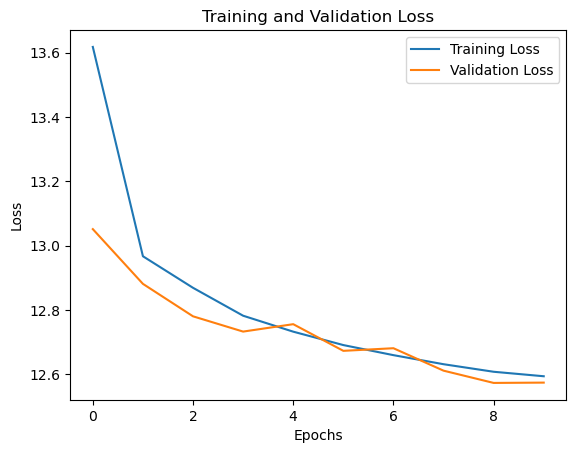

13108/13108 [==============================] - 23s 2ms/step
Original Features:
# FP1-F7    0.063113
C3-P3       0.093273
C4-P4       0.244153
CZ-PZ       0.277861
F3-C3       0.104552
F4-C4       0.054884
F7-T7       0.008408
F8-T8      -0.013788
FP1-F3     -0.144388
FP2-F4      0.017173
FP2-F8      0.084123
FT10-T8    -0.092775
FT9-FT10   -0.184664
FZ-CZ       0.139739
P3-O1       0.200328
P4-O2      -0.069648
P7-O1       0.126163
P7-T7      -0.021148
P8-O2      -0.138193
T7-FT9      0.164554
T7-P7       0.020979
T8-P8-0     0.278881
T8-P8-1     0.278881
Name: 8, dtype: float32

Reconstructed Features:
[-0.08934345 -0.03919302 -0.00387435 -0.00679516 -0.0934355  -0.05423407
 -0.08833556 -0.08591811 -0.12998953 -0.14822674 -0.09796463 -0.10274725
 -0.02280795 -0.09035465  0.03546464  0.04868494  0.01373467  0.05376987
  0.01892417  0.06490726 -0.05382491 -0.00822728 -0.00822867]


In [7]:


# Remove the last column (outcome column)
data = data.iloc[:, :-1]

# Preprocess the data
data = data.astype('float32')  # Convert data to float32
data = (data - data.mean()) / data.std()  # Normalize the data

# Split the data into training and validation sets
train_data = data.sample(frac=0.8, random_state=42)
val_data = data.drop(train_data.index)

# Define the VAE model
latent_dim = 10  # Dimensionality of the latent space

# Encoder
encoder_inputs = keras.Input(shape=(23,))
x = layers.Dense(128, activation="relu")(encoder_inputs)
x = layers.Dense(64, activation="relu")(x)
z_mean = layers.Dense(latent_dim)(x)
z_log_var = layers.Dense(latent_dim)(x)

# Sampling layer
def sampling(args):
    z_mean, z_log_var = args
    epsilon = tf.random.normal(shape=tf.shape(z_mean))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_var])

# Decoder
decoder_inputs = layers.Dense(64, activation="relu")(z)
decoder_outputs = layers.Dense(23, activation="linear")(decoder_inputs)

# Define the VAE model
vae = keras.Model(encoder_inputs, decoder_outputs)

# Define the loss function
reconstruction_loss = keras.losses.mse(encoder_inputs, decoder_outputs)
reconstruction_loss *= 23  # Number of features

kl_loss = -0.5 * tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=-1)
vae_loss = tf.reduce_mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)

# Compile the model
vae.compile(optimizer="adam")

# Train the VAE model
history = vae.fit(train_data, train_data, epochs=10, batch_size=128, validation_data=(val_data, val_data), verbose=1)

# Reduce the dimensionality of the features
encoder = keras.Model(encoder_inputs, z_mean)
encoded_data = encoder.predict(data)

# Print the reduced dimensionality
print("Reduced Dimensionality:", encoded_data.shape[1])

# Print the training and validation loss curves
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Print a sample of the reconstructed features
decoded_data = vae.predict(val_data)
sample_index = 0  # Select a sample index
print("Original Features:")
print(val_data.iloc[sample_index])
print("\nReconstructed Features:")
print(decoded_data[sample_index])
